## Gemma 3

- **Multimodal input** image, audio and text
- **Matryoshka Transformer** selective activation of parameters to reduce compute cost and response times
- **Conditional parameter loading** do not load vision and audio parameters when not needed (e.g. for text tasks)

https://huggingface.co/google/gemma-3n-E4B-it

In [2]:
!nvidia-smi

Fri Jun 27 09:40:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   47C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

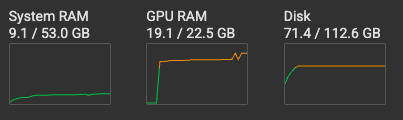

In [78]:
# Usage

In [34]:
%pip install -Uqqq pip --progress-bar off
%pip install -qqq timm==1.0.16 --progress-bar off
%pip install -qqq transformers==4.53.0 --progress-bar off
%pip install -qqq av==14.4.0 --progress-bar off

In [35]:
from transformers import AutoProcessor, Gemma3nForConditionalGeneration
from PIL import Image
import torch
import textwrap
import av

In [1]:
model_id = "google/gemma-3n-e4b-it"

model = Gemma3nForConditionalGeneration.from_pretrained(
    model_id, device_map="auto", torch_dtype=torch.bfloat16
).eval()

processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

In [27]:
def print_response(text: str):
    lines = text.split("\n")
    for line in lines:
        print(textwrap.fill(line, 100))

In [31]:
def predict(
    messages: list[dict],
    processor: AutoProcessor,
    model: Gemma3nForConditionalGeneration,
) -> str:
    inputs = processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    ).to(model.device)

    input_len = inputs["input_ids"].shape[-1]

    with torch.inference_mode():
        generation = model.generate(**inputs, max_new_tokens=140, do_sample=False)
        generation = generation[0][input_len:]

    return processor.decode(generation, skip_special_tokens=True)

In [24]:
system_message = {
    "role": "system",
    "content": [{"type": "text", "text": "You are a helpful assistant."}],
}

In [77]:
%%time
messages = [
    system_message,
    {"role": "user", "content": [{"type": "text", "text": "Hi, what is your name?"}]},
]
result = predict(messages, processor, model)

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 2.29 s, sys: 30.3 ms, total: 2.32 s
Wall time: 2.31 s


In [14]:
print_response(result)

Hello! I'm Gemma, a large language model created by the Gemma team at Google DeepMind. I'm an open-
weights AI assistant. It's nice to meet you!



## Images

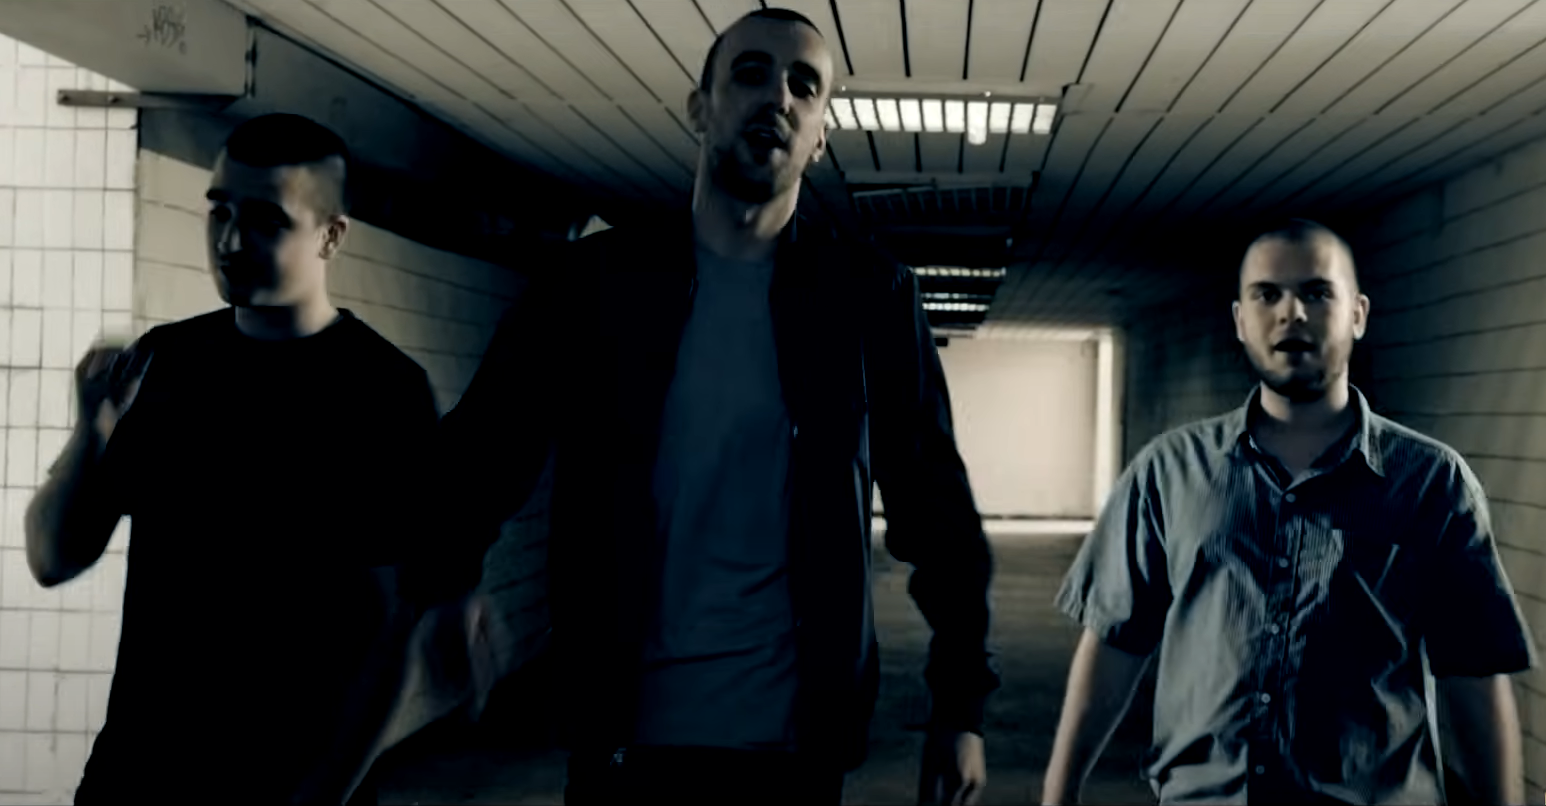

In [15]:
people_image = Image.open("people.png").convert("RGB")
people_image

In [76]:
%%time
messages = [
    system_message,
    {
        "role": "user",
        "content": [
            {"type": "image", "image": people_image},
            {
                "type": "text",
                "text": "How many people on the image? Describe their gender. Sort them by height.",
            },
        ],
    },
]
result = predict(messages, processor, model)

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 5.04 s, sys: 63.2 ms, total: 5.1 s
Wall time: 5.02 s


In [18]:
print_response(result)

There are **three** people in the image.

Based on their appearance, all three individuals appear to be **male**.

Sorting them by height (from tallest to shortest, based on visual estimation):

1. **The person at the top** appears to be the tallest.
2. **The person in the middle** is slightly shorter than the top person.
3. **The person at the bottom** appears to be the shortest.


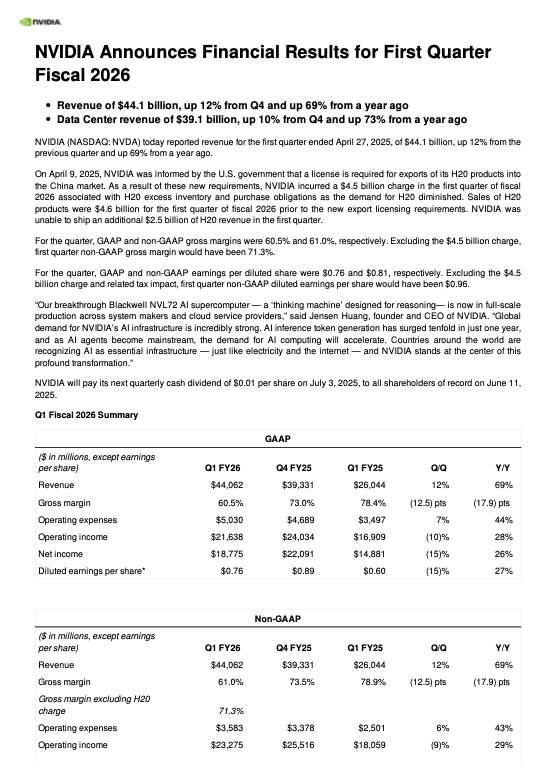

In [19]:
earnings_image = Image.open("nvidia-earnings.png").convert("RGB")
earnings_image

In [25]:
%%time
messages = [
    system_message,
    {
        "role": "user",
        "content": [
            {"type": "image", "image": earnings_image},
            {
                "type": "text",
                "text": "Give 1-2 sentence summary of what is on the image. How much is the diluted earings per share for Q1 FY26 (GAAP)?",
            },
        ],
    },
]
result = predict(messages, processor, model)

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 1min 9s, sys: 9.14 s, total: 1min 18s
Wall time: 1min 18s


In [26]:
print_response(result)

The image contains financial statements for ADWIA for the fiscal year 2025, specifically showing the
results for the first quarter (Q1 FY26). It presents a detailed breakdown of revenues, expenses, and
earnings under both GAAP and non-GAAP accounting methods.

The diluted earnings per share for Q1 FY26 (GAAP) is **0.80**.


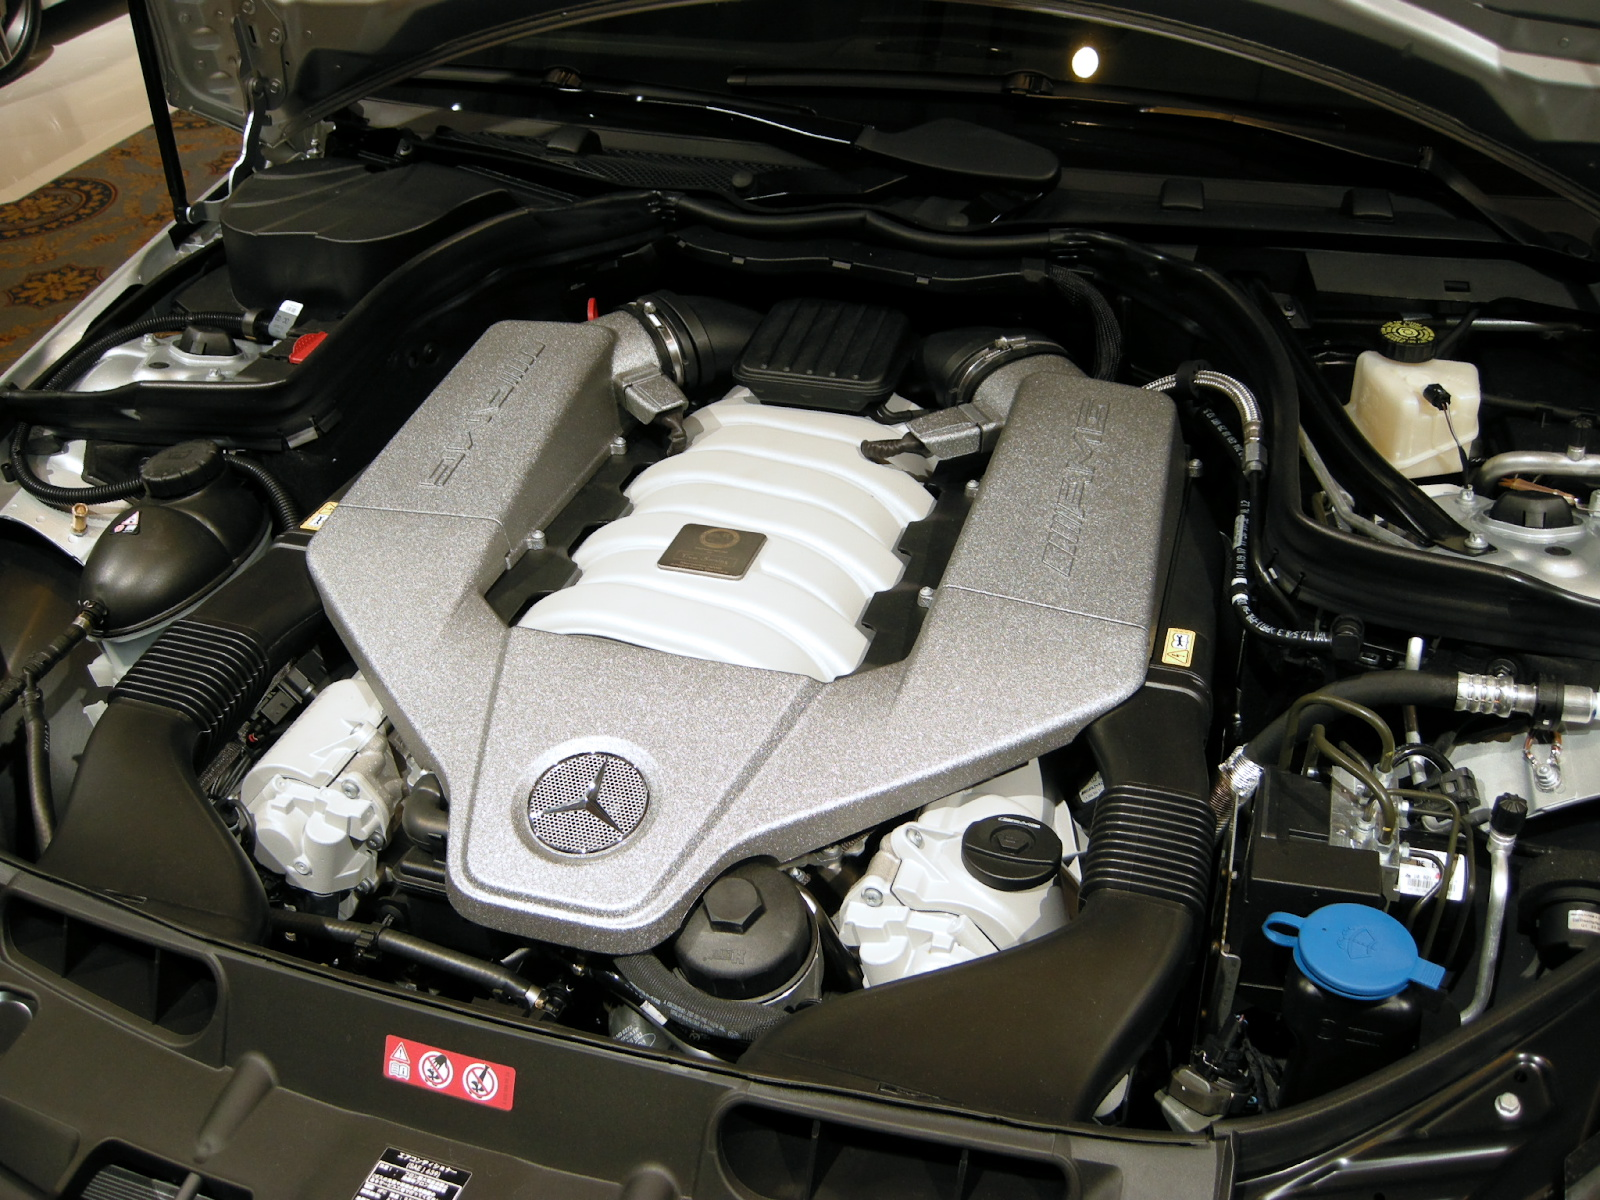

In [28]:
engine_image = Image.open("engine.jpeg").convert("RGB")
engine_image

In [32]:
%%time
messages = [
    system_message,
    {
        "role": "user",
        "content": [
            {"type": "image", "image": engine_image},
            {
                "type": "text",
                "text": "What engine is this? What is the displacement and horsepower?",
            },
        ],
    },
]
result = predict(messages, processor, model)

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 1min 12s, sys: 9.19 s, total: 1min 22s
Wall time: 1min 21s


In [33]:
print_response(result)

Based on the image, this is a **Mercedes-AMG M156 V8 engine**.

Here's what we can tell about its displacement and horsepower:

* **Displacement:** The M156 engine has a displacement of **6.2 liters (388 cu in)**.
* **Horsepower:** The horsepower varies depending on the specific model and year it was used in.
However, typical horsepower figures for the M156 range from **451 to 503 horsepower** depending on
the variant (e.g., in the C63 AMG).

The "AMG" badging and the overall design of the engine cover are


## Video

In [69]:
container = av.open("video.mp4")
frames = []
for i, frame in enumerate(container.decode(video=0)):
    if i % 20 == 0:
        frames.append(frame.to_image().rotate(-90))
len(frames)

7

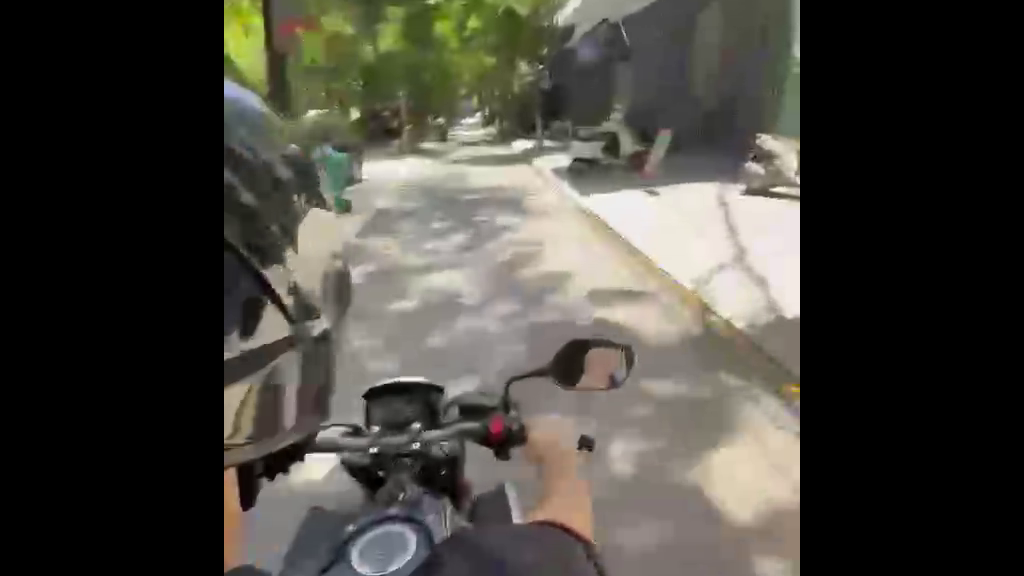

In [70]:
frames[5]

In [73]:
%%time
messages = [
    system_message,
    {
        "role": "user",
        "content": [
            *[{"type": "image", "image": frame} for frame in frames[1:]],
            {"type": "text", "text": "What is happening in the images?"},
        ],
    },
]
result = predict(messages, processor, model)

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 8.36 s, sys: 490 ms, total: 8.85 s
Wall time: 8.5 s


In [75]:
print_response(result)

Here's what appears to be happening in the images:

**The images show a person on a motorcycle attempting to perform a wheelie.**

Here's a breakdown of what's visible:

* **Motorcycle:** A motorcycle is the central focus in all the images.
* **Wheelie:** The motorcycle is tilted back, with the front wheel lifted off the ground. This is a
maneuver known as a wheelie.
* **Rider:** A person is riding the motorcycle and appears to be controlling the wheelie.
* **Street/Road:** The action is taking place on a paved surface, likely a street or road.
* **Surroundings
